In [37]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate
# from keras.utils.vis_utils import plot_model

In [38]:
input_shape = (224, 224, 3)
image_size = (224,224)
def preProcess(img):
    img = cv.resize(img, image_size, 
               interpolation = cv.INTER_LINEAR)
    img = to_hsv(img)
    return img


def to_hsv(img):

  hue_shift = 180  
  saturation_scale = 2
  value_scale = 5

  # img[..., 0] = (img[..., 0] + hue_shift) % 180 
  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  img[..., 2] = cv.equalizeHist(img[..., 2])

  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
  # img = cv.equalizeHist(img)
  return img

In [39]:
train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

train_data = []
train_jenis = []
train_warna =[]

test_data = []
test_ids = []


for i in os.listdir(train_dir):
    if(i is not None):
        img = cv.imread(train_dir+i)
        img = preProcess(img)

        train_data.append(img)

        cond = train_df['id'] == int(i[:-4])
        idx = train_df.loc[cond].index[0]
        train_jenis.append(train_df.iloc[idx]['jenis'])
        train_warna.append(train_df.iloc[idx]['warna'])

for i in os.listdir(test_dir):
    if(i is not None):
        img = cv.imread(test_dir+i)
        img = preProcess(img)
        test_data.append(img)
        test_ids.append(i[:-4])


print(len(train_data))
print(len(train_jenis))
print(len(train_warna))

xtrain_data, xval_data, ytrain_jenis, yval_jenis, ytrain_warna, yval_warna = train_test_split(
    train_data, train_jenis, train_warna, test_size=0.2, random_state=42
)

print(len(test_data))
print(len(test_ids))
    


777
777
777
334
334


In [40]:
def plot_image(img):
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.show()

In [41]:
def ColorNet(input, nb_class):
    top_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    flatten = Flatten()(conv_output)

    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=nb_class)(FC_2)
    output = Activation("softmax")(output)

    return output


In [42]:
def rgb_to_grayscale(x):
    return tf.image.rgb_to_grayscale(x)

def CategoryNet(input, nb_class):

    # print(input.shape)
    # x = Lambda(rgb_to_grayscale)(input)
    # print("Shape after grayscale conversion:", x.shape)
    # x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(x)
    x = Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu')(input)


    x = MaxPooling2D(pool_size=(5, 5), strides=(2,2), padding='valid')(x)

    x = Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid')(x)

    x = Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)
    x = Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)
    # x = Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='valid', activation='relu')(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)

    x = Dense(nb_class, activation='softmax', name="category_output")(x)

    return x

In [43]:
train_warna_categorical = to_categorical(train_warna,num_classes=len(np.unique(train_warna)))
train_jenis_categorical = to_categorical(train_jenis,num_classes=len(np.unique(train_jenis)))

# xtrain_data, xval_data, ytrain_jenis, yval_jenis, ytrain_warna, yval_warna
ytrain_jenis = to_categorical(ytrain_jenis,num_classes=len(np.unique(ytrain_jenis)))
ytrain_warna = to_categorical(ytrain_warna,num_classes=len(np.unique(ytrain_warna)))
yval_jenis = to_categorical(yval_jenis,num_classes=len(np.unique(yval_jenis)))
yval_warna = to_categorical(yval_warna,num_classes=len(np.unique(yval_warna)))

xtrain_data = np.array(xtrain_data)
xval_data = np.array(xval_data)

print(train_warna_categorical)
print(ytrain_warna)


inp = Input(input_shape)

colorBranch = ColorNet(input=inp, nb_class=len(np.unique(train_warna)))
categoryBranch = CategoryNet(input=inp, nb_class=len(np.unique(train_jenis)))
color_model = Model(
			inputs=inp,
			outputs=colorBranch,
            )

category_model = Model(
    inputs=inp,
    outputs=categoryBranch
)

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [44]:
opt = Adam(learning_rate=0.0001)


color_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

history = color_model.fit(xtrain_data,ytrain_warna, batch_size= 16, epochs=50,validation_data=(xval_data,yval_warna))
    

Epoch 1/50


39/39 [==============================] - 2s 30ms/step - loss: 2.6694 - accuracy: 0.2528 - val_loss: 1.7445 - val_accuracy: 0.2372
Epoch 2/50
39/39 [==============================] - 1s 26ms/step - loss: 1.6018 - accuracy: 0.3671 - val_loss: 1.4828 - val_accuracy: 0.3269
Epoch 3/50
39/39 [==============================] - 1s 25ms/step - loss: 1.3033 - accuracy: 0.4863 - val_loss: 1.3695 - val_accuracy: 0.4423
Epoch 4/50
39/39 [==============================] - 1s 25ms/step - loss: 1.1444 - accuracy: 0.5684 - val_loss: 1.2888 - val_accuracy: 0.4551
Epoch 5/50
39/39 [==============================] - 1s 25ms/step - loss: 0.9900 - accuracy: 0.6264 - val_loss: 1.1900 - val_accuracy: 0.5256
Epoch 6/50
39/39 [==============================] - 1s 25ms/step - loss: 0.8179 - accuracy: 0.6940 - val_loss: 1.0646 - val_accuracy: 0.6218
Epoch 7/50
39/39 [==============================] - 1s 25ms/step - loss: 0.6547 - accuracy: 0.7585 - val_loss: 1.1078 - val_accuracy: 0.5705
Epoch 8/50
39/39 [======

In [45]:
score = color_model.evaluate(xtrain_data,ytrain_warna)

print("Loss and metrics for each output:", score)


20/20 [==============================] - 0s 8ms/step - loss: 0.0547 - accuracy: 0.9839
Loss and metrics for each output: [0.054738711565732956, 0.9838969111442566]


Total Test Loss: 0.054738711565732956
Color Output Loss: 0.9838969111442566


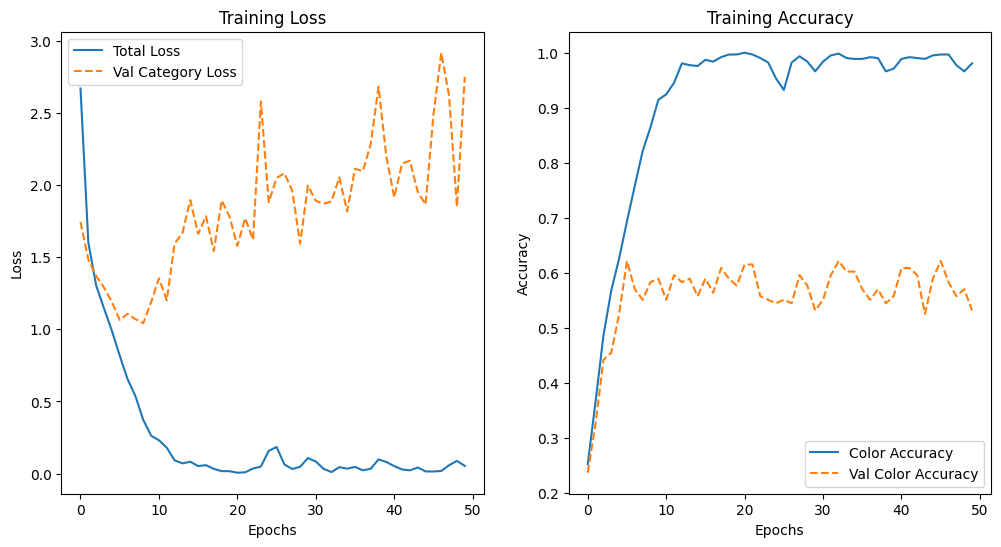

In [46]:
print('Total Test Loss:', score[0])  
print('Color Output Loss:', score[1]) 

totall = len(history.history['loss'])


totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

# print(history.history)

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
# plt.plot(range(totall), history.history['category_output_loss'], label='Category Loss')
# plt.plot(range(totall), history.history['color_output_loss'], label='Color Loss')


plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')
# plt.plot(range(totall), history.history['val_color_output_loss'], label='Val Color Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Color Accuracy') 
# plt.plot(range(totall), history.history['color_output_accuracy'], label='Color Accuracy')

plt.plot(range(totall), history.history['val_accuracy'], label='Val Color Accuracy', linestyle='--')
# plt.plot(range(totall), history.history['val_color_output_accuracy'], label='Val Color Accuracy', linestyle='--')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [48]:
opt = Adam(learning_rate=0.0001)


category_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])
    

history = category_model.fit(xtrain_data,ytrain_jenis, batch_size= 16, epochs=50,validation_data=(xval_data,yval_jenis))
    

Epoch 1/50
39/39 [==============================] - 1s 22ms/step - loss: 0.6216 - accuracy: 0.6409 - val_loss: 0.4386 - val_accuracy: 0.7885
Epoch 2/50
39/39 [==============================] - 1s 16ms/step - loss: 0.4672 - accuracy: 0.7601 - val_loss: 0.5069 - val_accuracy: 0.7179
Epoch 3/50
39/39 [==============================] - 1s 15ms/step - loss: 0.3773 - accuracy: 0.8019 - val_loss: 0.3656 - val_accuracy: 0.8205
Epoch 4/50
39/39 [==============================] - 1s 15ms/step - loss: 0.3139 - accuracy: 0.8309 - val_loss: 0.4170 - val_accuracy: 0.8141
Epoch 5/50
39/39 [==============================] - 1s 16ms/step - loss: 0.2359 - accuracy: 0.8921 - val_loss: 0.3862 - val_accuracy: 0.8397
Epoch 6/50
39/39 [==============================] - 1s 15ms/step - loss: 0.1256 - accuracy: 0.9485 - val_loss: 0.4209 - val_accuracy: 0.8205
Epoch 7/50
39/39 [==============================] - 1s 15ms/step - loss: 0.1928 - accuracy: 0.9082 - val_loss: 0.5052 - val_accuracy: 0.7372
Epoch 8/50
39

20/20 [==============================] - 0s 13ms/step - loss: 2.5045e-06 - accuracy: 1.0000
Loss and metrics for each output: [2.504501935618464e-06, 1.0]
Total Test Loss: 2.504501935618464e-06
Color Output Loss: 1.0


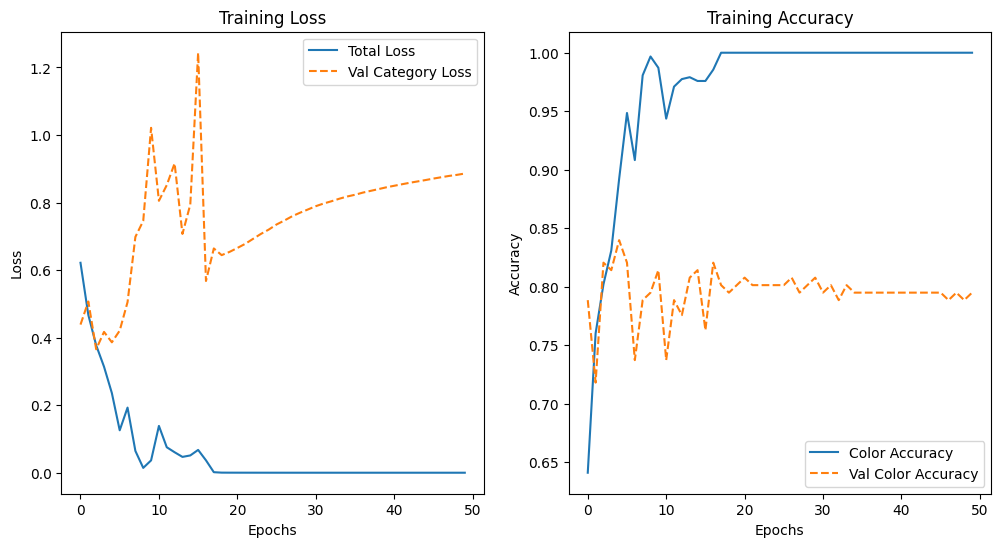

In [52]:
score = category_model.evaluate(xtrain_data,ytrain_jenis)

print("Loss and metrics for each output:", score)

print('Total Test Loss:', score[0])  
print('Color Output Loss:', score[1]) 

totall = len(history.history['loss'])


totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

# print(history.history)

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
# plt.plot(range(totall), history.history['category_output_loss'], label='Category Loss')
# plt.plot(range(totall), history.history['color_output_loss'], label='Color Loss')


plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')
# plt.plot(range(totall), history.history['val_color_output_loss'], label='Val Color Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Color Accuracy') 
# plt.plot(range(totall), history.history['color_output_accuracy'], label='Color Accuracy')

plt.plot(range(totall), history.history['val_accuracy'], label='Val Color Accuracy', linestyle='--')
# plt.plot(range(totall), history.history['val_color_output_accuracy'], label='Val Color Accuracy', linestyle='--')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()


In [57]:
print(test_data[0].shape)
test_data = np.array(test_data)
prediction_jenis = category_model.predict(test_data)
prediction_warna = color_model.predict(test_data)

final_jenis = []
final_warna = []

for p_jenis, p_warna in zip(prediction_jenis,prediction_warna):
    # print(id)
    final_jenis.append(np.argmax(p_jenis))
    final_warna.append(np.argmax(p_warna))
    # print("============")
final = pd.DataFrame({'id':test_ids, 'jenis': final_jenis,'warna': final_warna})
# display(final)
final.to_csv('submission.csv', index=False)
    

(224, 224, 3)
11/11 [==============================] - 0s 13ms/step
